In [40]:
import pandas as pd
import numpy as np

import spacy
import nltk
import nltk.data
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import regex as re
import string
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from simpletransformers.classification import ClassificationModel


import io

In [41]:
df = pd.read_csv('../data/input_tweets.csv')
print(f'Columns: {df.columns}')
print(f'Shape: {df.shape}')
print(f'Types: {df.dtypes}')
print(df.head())

Columns: Index(['Unnamed: 0', 'username', 'acctdesc', 'location', 'following',
       'followers', 'totaltweets', 'usercreatedts', 'tweetcreatedts',
       'retweetcount', 'hashtags', 'text', 'target'],
      dtype='object')
Shape: (2000, 13)
Types: Unnamed: 0         int64
username          object
acctdesc          object
location          object
following          int64
followers          int64
totaltweets        int64
usercreatedts     object
tweetcreatedts    object
retweetcount       int64
hashtags          object
text              object
target             int64
dtype: object
   Unnamed: 0         username  \
0           0  cristia89872894   
1           2      sccristiano   
2          12      Atorrante15   
3          16          _fedenb   
4          20  javier_eduardo3   

                                                                                                                                         acctdesc  \
0  Hincha del Apruebo, pero nunca de los Apruebistas...mi

In [42]:
df['target'] = df['target'].astype(int)

In [43]:
df.drop(columns = ['Unnamed: 0'], inplace = True)

nulls = pd.DataFrame(np.c_[df.isnull().sum(), (df.isnull().sum()/ len(df))*100],
                     columns = ['Num of nulls', '% of nulls'],
                     index = df.columns)
print(nulls)

                Num of nulls  % of nulls
username                 0.0         0.0
acctdesc               350.0        17.5
location               808.0        40.4
following                0.0         0.0
followers                0.0         0.0
totaltweets              0.0         0.0
usercreatedts            0.0         0.0
tweetcreatedts           0.0         0.0
retweetcount             0.0         0.0
hashtags                 0.0         0.0
text                     0.0         0.0
target                   0.0         0.0


In [44]:
df['acctdesc'].fillna('no_acctdesc', inplace = True)
df['location'].fillna('no_location', inplace = True)

print(f'Number of unique values in acctdesc = {df["acctdesc"].nunique()}')
print(f'Number of unique values in location = {df["location"].nunique()}')

Number of unique values in acctdesc = 1479
Number of unique values in location = 719


In [45]:
df.drop(columns = ['acctdesc'], inplace = True)

In [46]:
df.groupby(['location']).count().text.sort_values(ascending = False)

location
no_location                  808
España                        67
Madrid                        35
Buenos Aires, Argentina       23
Santiago, Chile               22
                            ... 
Gibraltar Español              1
Gibraltar, Español             1
Gijón - Asturias - España      1
Globolandia                    1
🚀🌍                             1
Name: text, Length: 719, dtype: int64

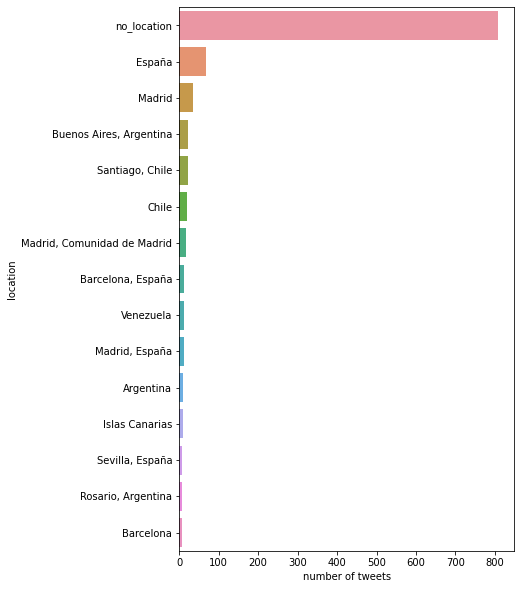

In [47]:
top_15 = df.groupby(['location']).count().text.sort_values(ascending = False)[:15]

plt.figure(figsize = (6,10))
sns.barplot(x = top_15, y = top_15.index)
plt.xlabel('number of tweets');

In [48]:
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 42)

print(f'Training set shape: {df_train.shape}')
print(f'Test set shape: {df_test.shape}')

Training set shape: (1400, 11)
Test set shape: (600, 11)


In [49]:
punctuations = "¡!#$%&'()*+,-./:;<=>¿?@[\]^_`{|}~"

def read_txt(filename):
    list = []
    with open(filename, 'r', encoding='utf-8') as f:
        data = f.readlines()
        for line in data:
            list.append(str(line).replace('\n', ''))
    return list

stopwords = read_txt('../data/spanish_stopwords.txt')

stemmer = SnowballStemmer('spanish')

In [50]:
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

def unique_word_count(x):
  return len(set(str(x).split()))

df_train['unique_count'] = df_train['text'].apply(unique_word_count)
df_test['unique_count'] = df_test['text'].apply(unique_word_count)

def count_stop_words(x):
  stopwords_list = []
  for word in str(x).lower().split():
    if word in stopwords:
      stopwords_list.append(word)
  return len(stopwords_list)

df_train['stop_word_count']= df_train['text'].apply(count_stop_words)
df_test['stop_word_count']= df_test['text'].apply(count_stop_words)

def count_hashtags(x):
    return x.count('{')

df_train['hashtag_count'] = df_train['hashtags'].apply(count_hashtags)
df_test['hashtag_count'] = df_test['hashtags'].apply(count_hashtags)

df_train['valid_words_count'] = df_train['word_count'] - df_train['stop_word_count']
df_test['valid_words_count'] = df_test['word_count'] - df_test['stop_word_count']

def unique_valid_words(x):
  words_set = set(str(x).split())
  for elem in stopwords:
    words_set.discard(elem)
  return len(words_set)

df_train['unique_valid_words'] = df_train['text'].apply(unique_valid_words)
df_test['unique_valid_words'] = df_test['text'].apply(unique_valid_words)

def count_mentions(x):
  return len([w for w in x.split(' ') if '@' in w])

df_train['mentions_count'] = df_train['text'].apply(count_mentions)
df_test['mentions_count'] = df_test['text'].apply(count_mentions)

e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



e:\archivos de programa\python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
e:\archivos de programa\python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
e:\archivos de programa\python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

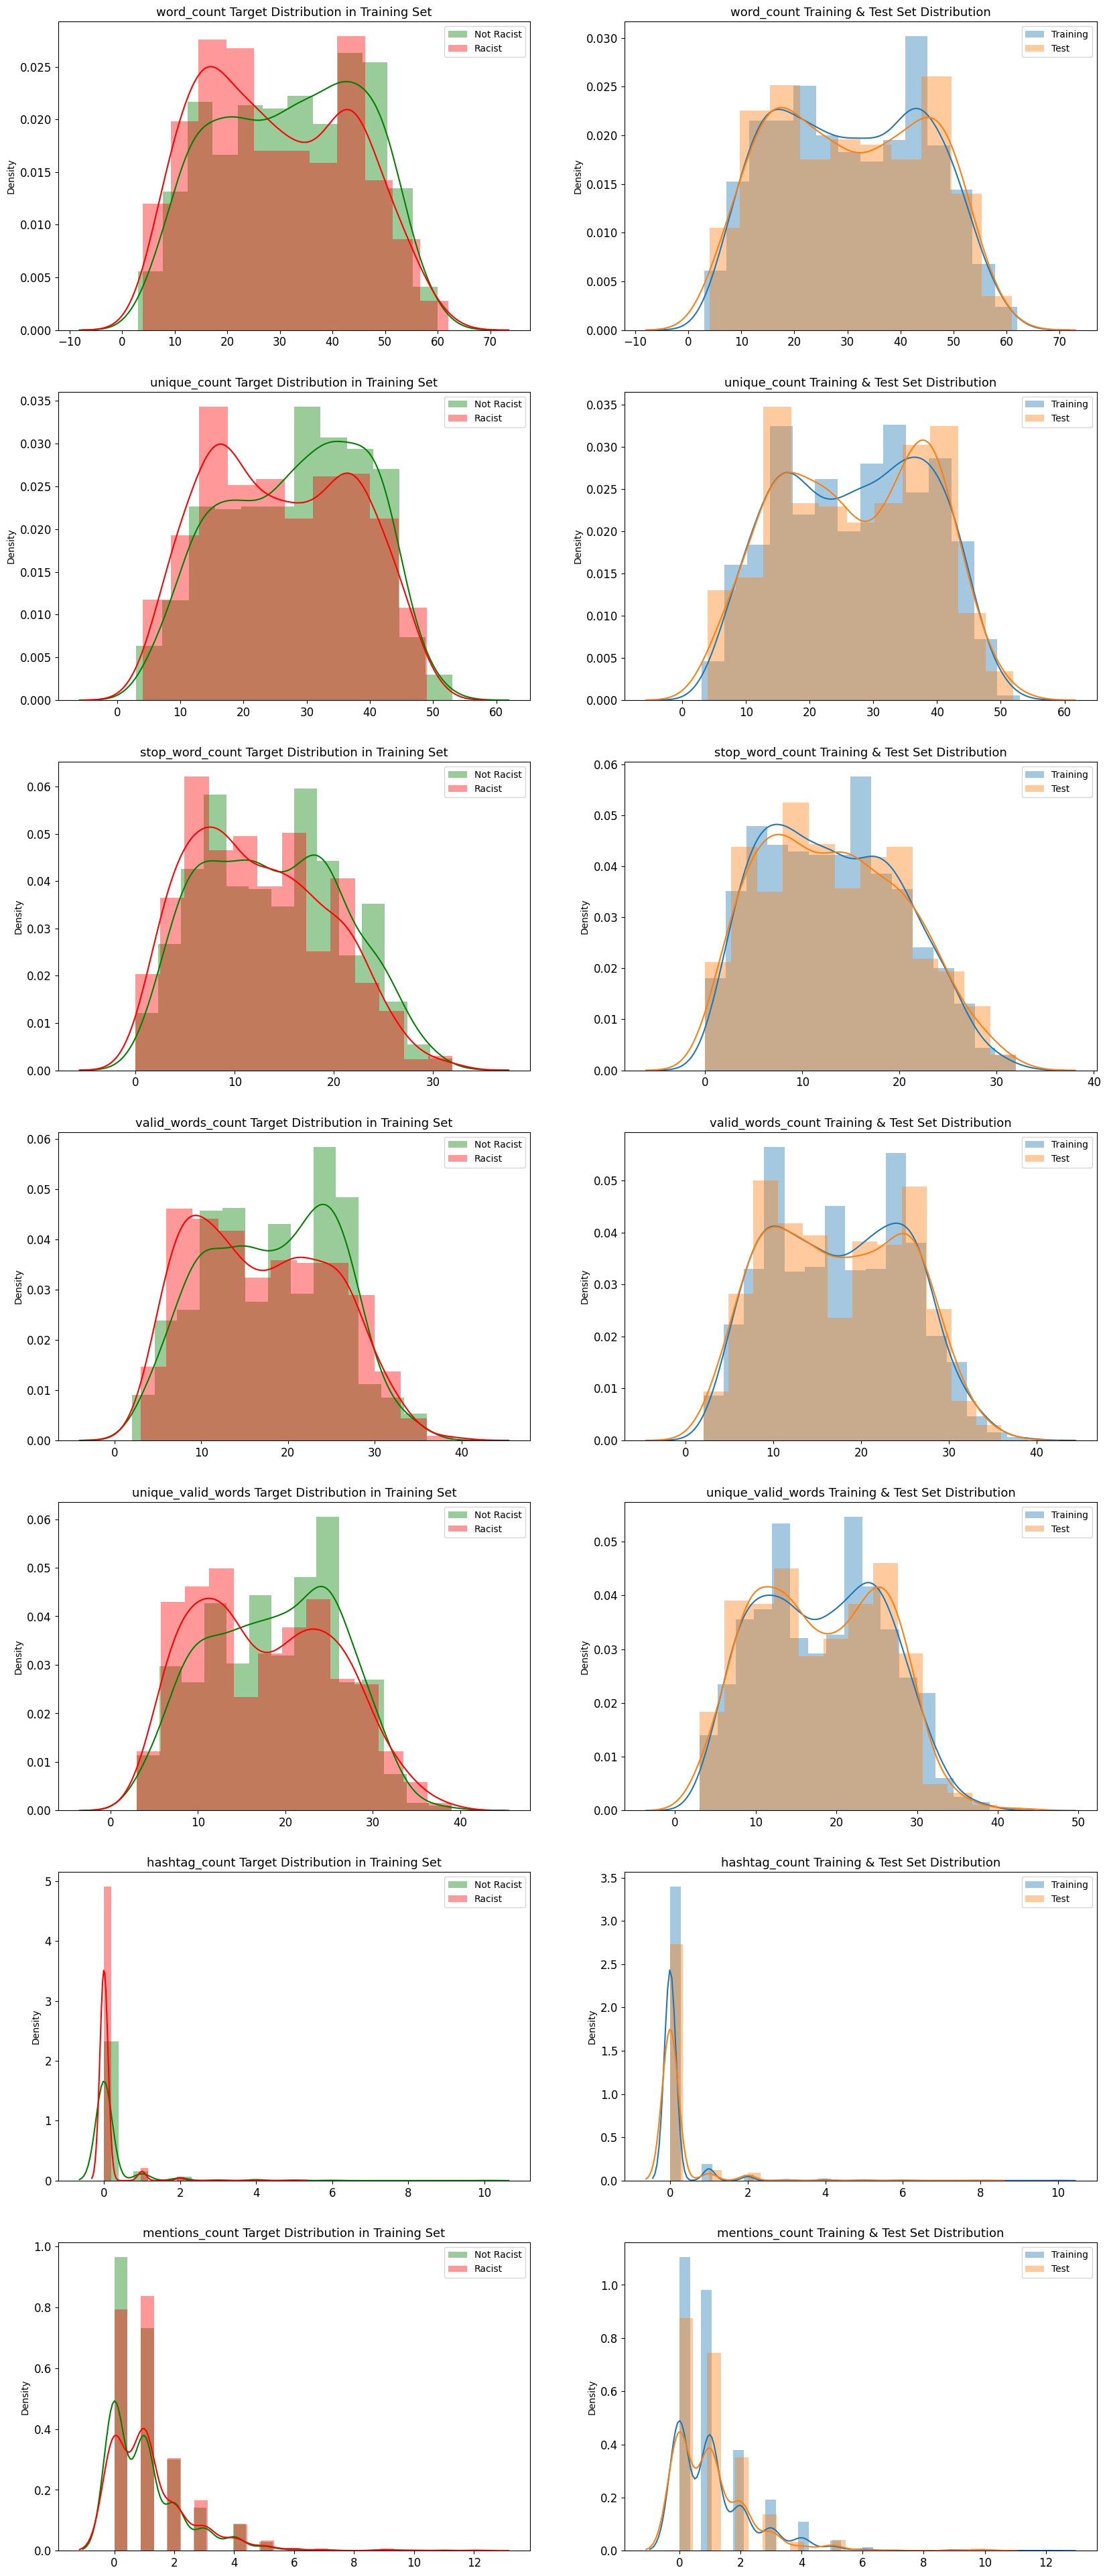

In [51]:
column_names = ['word_count', 'unique_count', 'stop_word_count', 'valid_words_count', 'unique_valid_words', 'hashtag_count', 'mentions_count']
racist_tweets = df_train['target'] == 1
fig, axes = plt.subplots(ncols=2, nrows=len(column_names), figsize=(20, 50), dpi=100)

for i, col_name in enumerate(column_names):
    sns.distplot(df_train.loc[~racist_tweets][col_name], label='Not Racist', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[racist_tweets][col_name], label='Racist', ax=axes[i][0], color='red')

    sns.distplot(df_train[col_name], label='Training', ax=axes[i][1])
    sns.distplot(df_test[col_name], label='Test', ax=axes[i][1])

    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()

    axes[i][0].set_title(f'{col_name} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{col_name} Training & Test Set Distribution', fontsize=13)

In [52]:
def clean_accents (tweet):
  tweet = re.sub(r"[àáâãäå]", "a", tweet)
  tweet = re.sub(r"ç", "c", tweet)
  tweet = re.sub(r"[èéêë]", "e", tweet)
  tweet = re.sub(r"[ìíîï]", "i", tweet)
  tweet = re.sub(r"[òóôõö]", "o", tweet)
  tweet = re.sub(r"[ùúûü]", "u", tweet)
  tweet = re.sub(r"[ýÿ]", "y", tweet)
  return tweet


In [53]:
def clean_tweet(tweet, stem = False):
    tweet = tweet.lower().strip()
    tweet = re.sub(r'https?:\/\/\S+', '', tweet)
    tweet = re.sub(r'http?:\/\/\S+', '', tweet)
    tweet = re.sub(r'www?:\/\/\S+', '', tweet)
    tweet = re.sub(r'\s([@#][\w_-]+)', "", tweet)
    tweet = re.sub(r"\n", " ", tweet)
    tweet = clean_accents(tweet)
    tweet = re.sub(r"\b(a*ha+h[ha]*|o?l+o+l+[ol]*|x+d+[x*d*]*|a*ja+[j+a+]+)\b", "<risas>", tweet)
    for symbol in punctuations:
        tweet = tweet.replace(symbol, "")
    tokens = []
    for token in tweet.strip().split():
        if token not in punctuations and token not in stopwords:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [54]:
df_train['text_cleaned'] = df_train['text'].apply(lambda s : clean_tweet(s))
df_test['text_cleaned'] = df_test['text'].apply(lambda s : clean_tweet(s))

e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [55]:
df_train.drop_duplicates(subset=['text_cleaned', 'username'], keep='last', inplace = True)
df_test.drop_duplicates(subset=['text_cleaned', 'username'], keep='last', inplace = True)


e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


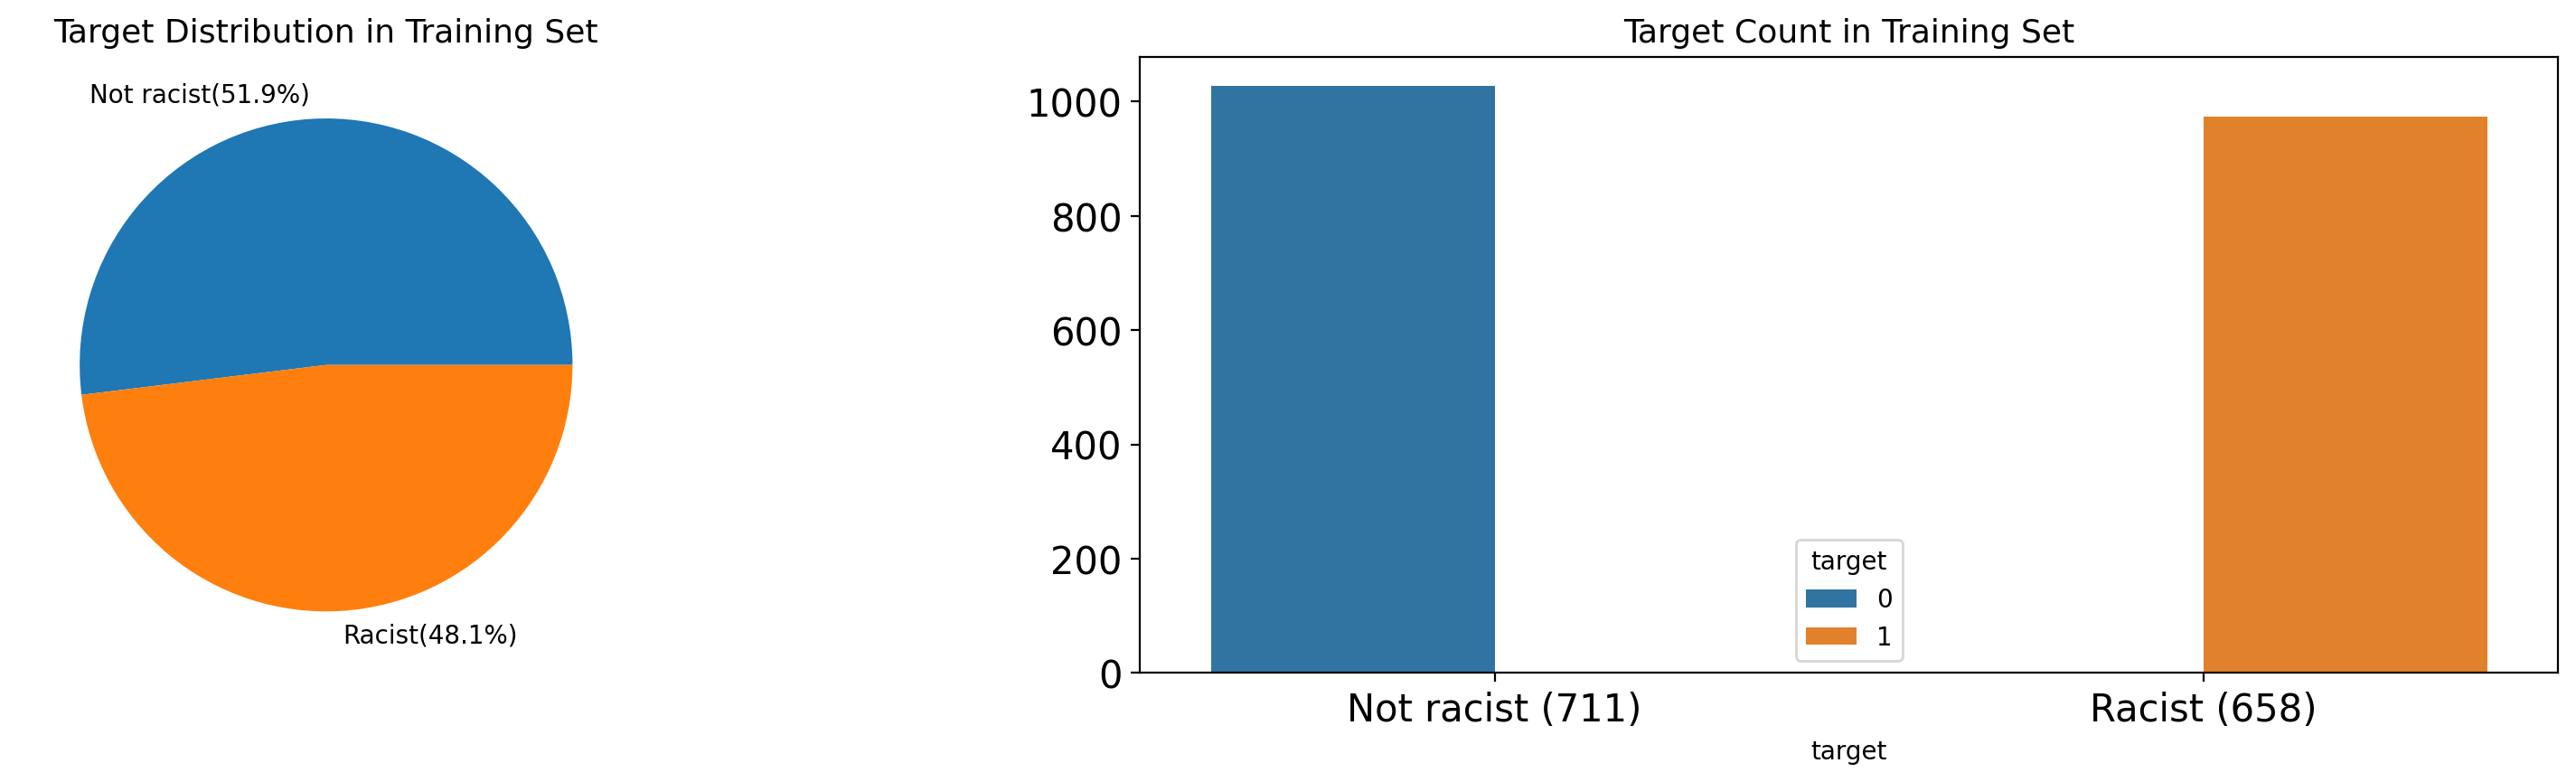

In [56]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=200)
plt.tight_layout()

target_count = df_train.groupby('target').count()['username']
not_racist_pct = round(target_count[0]/(target_count[0] + target_count[1]),3)
racist_pct = 1 - not_racist_pct

target_count.plot(kind='pie', ax=axes[0], labels=[f'Not racist({not_racist_pct*100}%)', f'Racist({racist_pct*100}%)'])
sns.countplot(x=df['target'], hue=df['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels([f'Not racist ({target_count[0]})', f'Racist ({target_count[1]})'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

In [57]:
def generate_ngrams(text, n_gram, stopwords):
  words = [w for w in text.lower().split(' ') if w != '' if w not in stopwords]
  if len(words) < n_gram:
    return []
  else:
    result = []
    for i in range(len(words) - n_gram+1):
      gram = ""
      for word in words[i:i+n_gram]:
        gram += word + " "
      gram = gram[:-1]
      result.append(gram)
    return result

In [58]:
N = 15

#Unigrams
racist_unigrams = defaultdict(int)
nonracist_unigrams = defaultdict(int)

for tweet in df_train[racist_tweets]['text_cleaned']:
  for word in generate_ngrams(tweet, 1, stopwords):
    racist_unigrams[word] += 1

for tweet in df_train[~racist_tweets]['text_cleaned']:
  for word in generate_ngrams(tweet, 1, stopwords):
    nonracist_unigrams[word] += 1

df_racist_unigrams = pd.DataFrame(sorted(racist_unigrams.items(), key=lambda x: x[1])[::-1])
df_nonracist_unigrams = pd.DataFrame(sorted(nonracist_unigrams.items(), key=lambda x: x[1])[::-1])

#Bigrams
racist_bigrams = defaultdict(int)
nonracist_bigrams = defaultdict(int)

for tweet in df_train[racist_tweets]['text_cleaned']:
  for word in generate_ngrams(tweet, 2, stopwords):
    racist_bigrams[word] += 1

for tweet in df_train[~racist_tweets]['text_cleaned']:
  for word in generate_ngrams(tweet, 2, stopwords):
    nonracist_bigrams[word] += 1

df_racist_bigrams = pd.DataFrame(sorted(racist_bigrams.items(), key=lambda x: x[1])[::-1])
df_nonracist_bigrams = pd.DataFrame(sorted(nonracist_bigrams.items(), key=lambda x: x[1])[::-1])

#Trigrams
racist_trigrams = defaultdict(int)
nonracist_trigrams = defaultdict(int)

for tweet in df_train[racist_tweets]['text_cleaned']:
  for word in generate_ngrams(tweet, 3, stopwords):
    racist_trigrams[word] += 1

for tweet in df_train[~racist_tweets]['text_cleaned']:
  for word in generate_ngrams(tweet, 3, stopwords):
    nonracist_trigrams[word] += 1

df_racist_trigrams = pd.DataFrame(sorted(racist_trigrams.items(), key=lambda x: x[1])[::-1])
df_nonracist_trigrams = pd.DataFrame(sorted(nonracist_trigrams.items(), key=lambda x: x[1])[::-1])

e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


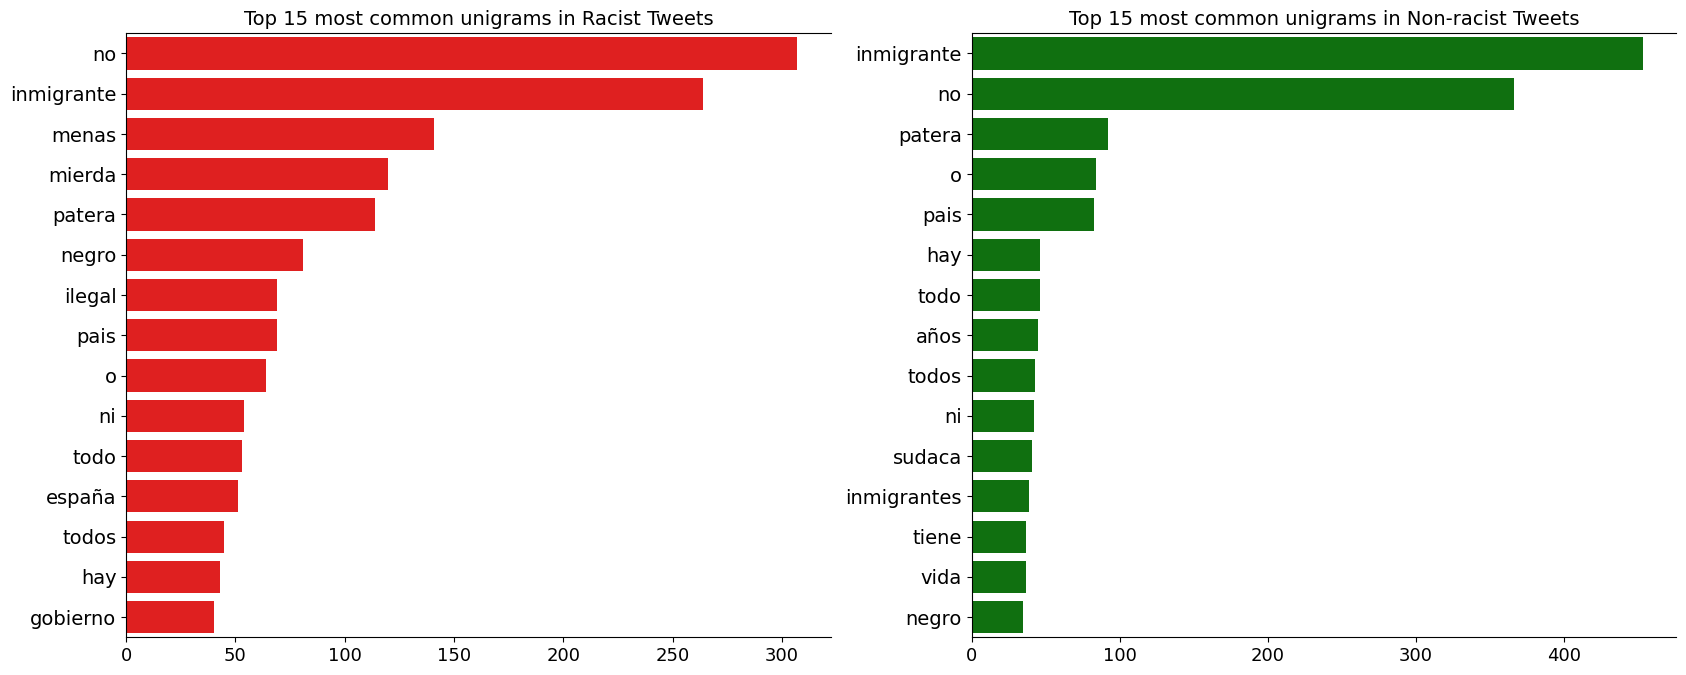

In [59]:
# PLot unigrams
fig, axes = plt.subplots(ncols=2, figsize=(20, 8), dpi=100)

sns.barplot(y=df_racist_unigrams[0].values[:N], x=df_racist_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nonracist_unigrams[0].values[:N], x=df_nonracist_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=14)

axes[0].set_title(f'Top {N} most common unigrams in Racist Tweets', fontsize=14)
axes[1].set_title(f'Top {N} most common unigrams in Non-racist Tweets', fontsize=14)

plt.show()

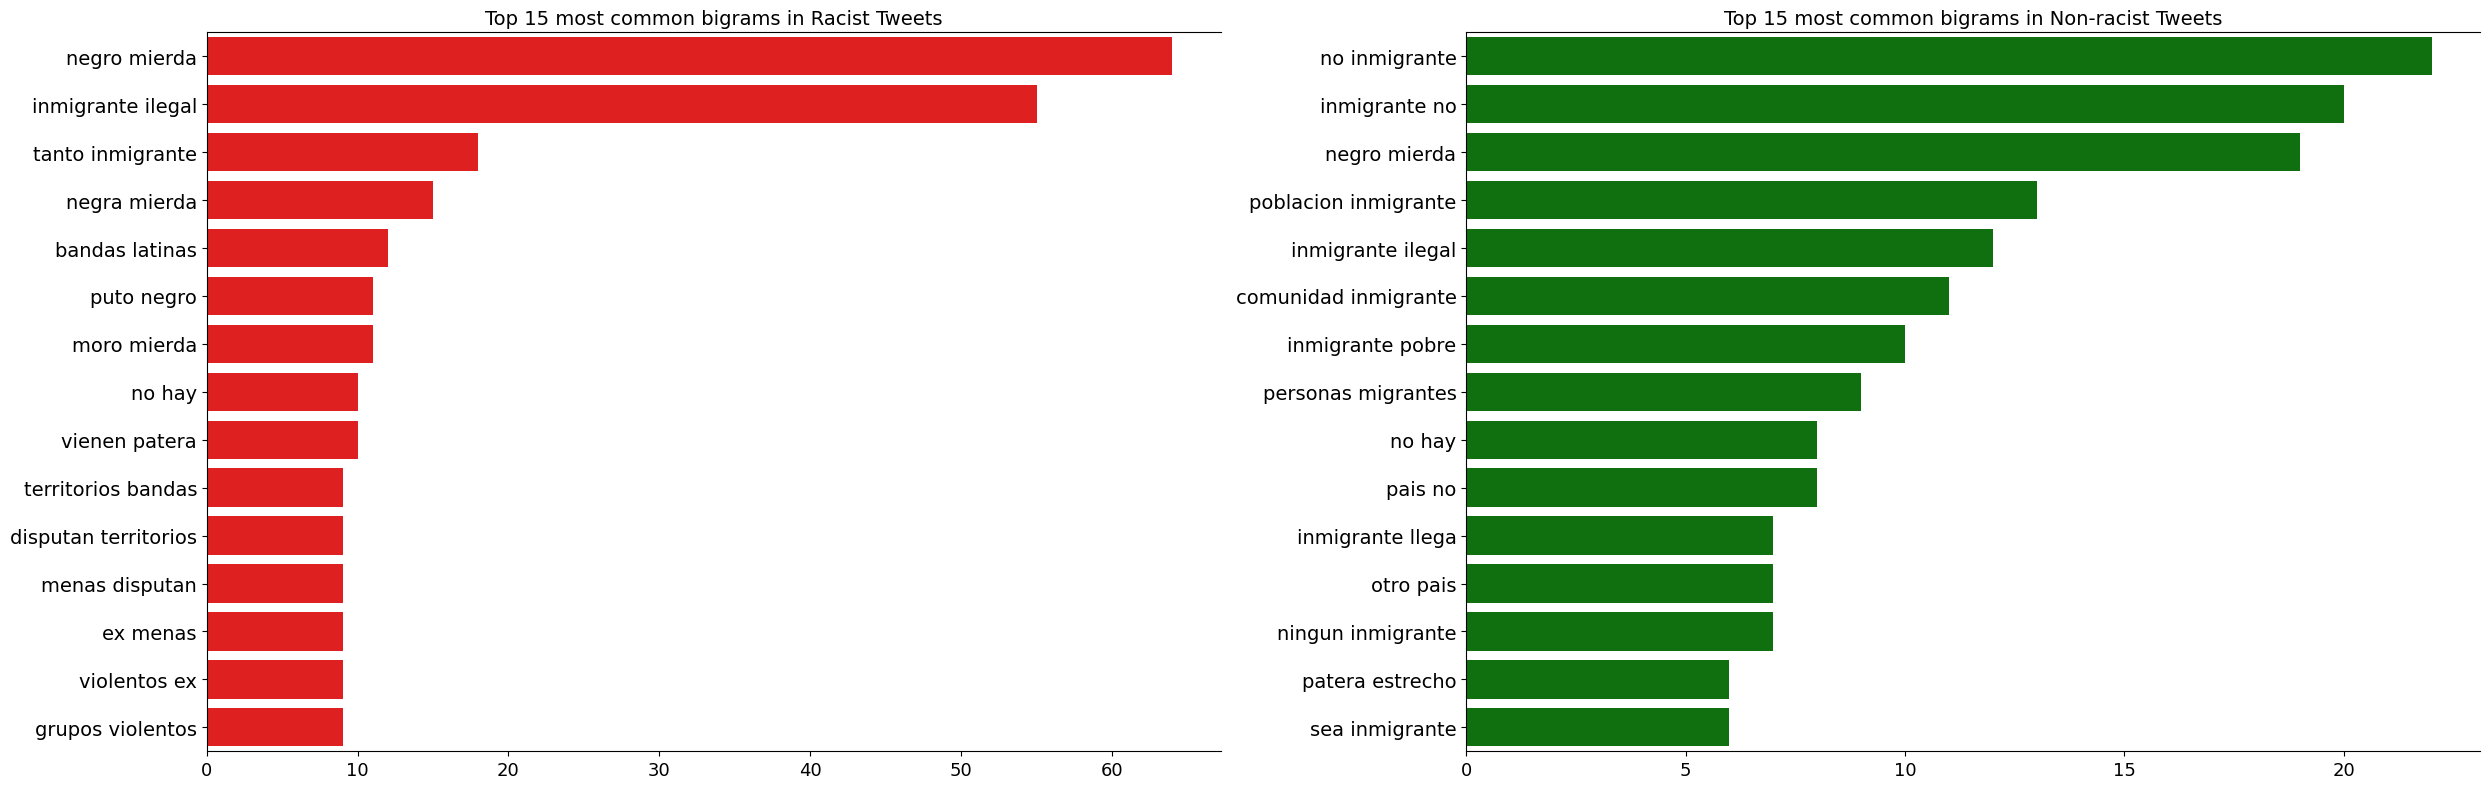

In [60]:
# PLot bigrams
fig, axes = plt.subplots(ncols=2, figsize=(25, 8), dpi=100)


sns.barplot(y=df_racist_bigrams[0].values[:N], x=df_racist_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nonracist_bigrams[0].values[:N], x=df_nonracist_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=14)

axes[0].set_title(f'Top {N} most common bigrams in Racist Tweets', fontsize=14)
axes[1].set_title(f'Top {N} most common bigrams in Non-racist Tweets', fontsize=14)
plt.tight_layout()
plt.show()

In [61]:
# PLot trigrams
fig, axes = plt.subplots(ncols=2, figsize=(18, 25), dpi=1000)
plt.tight_layout()

sns.barplot(y=df_racist_trigrams[0].values[:N], x=df_racist_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nonracist_trigrams[0].values[:N], x=df_nonracist_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common trigrams in Racist Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-racist Tweets', fontsize=15)

plt.show()

In [62]:
train_args ={"reprocess_input_data": True,
         "fp16":False,
          "num_train_epochs": 4,
             "do_lower_case": True}

model = ClassificationModel(
"bert", "dccuchile/bert-base-spanish-wwm-cased",
    use_cuda = False,
    args=train_args
)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased a

In [63]:
train_df = df_train[['text_cleaned', 'target']]
test_df = df_test[['text_cleaned', 'target']]
model.train_model(train_df)

e:\archivos de programa\python\lib\site-packages\simpletransformers\classification\classification_model.py:387: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
e:\archivos de programa\python\lib\site-packages\torch\optim\lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


  0%|          | 0/1369 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/172 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/172 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/172 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/172 [00:00<?, ?it/s]

(688, 0.2844050718186884)

In [64]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

result, model_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score)

print(result)


e:\archivos de programa\python\lib\site-packages\simpletransformers\classification\classification_model.py:966: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/589 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/74 [00:00<?, ?it/s]

{'mcc': 0.6104094179121587, 'tp': 221, 'tn': 253, 'fp': 47, 'fn': 68, 'f1': 0.8047538200339559, 'acc': 0.8047538200339559, 'eval_loss': 1.1339376538439743}


In [65]:
import os

print(os.listdir("outputs"))

['checkpoint-172-epoch-1', 'checkpoint-344-epoch-2', 'checkpoint-516-epoch-3', 'checkpoint-688-epoch-4', 'config.json', 'eval_results.txt', 'model_args.json', 'pytorch_model.bin', 'special_tokens_map.json', 'tokenizer_config.json', 'training_args.bin', 'vocab.txt']


In [66]:
import os
import tarfile

def pack_model(model_path='',file_name=''):
    files = [files for root, dirs, files in os.walk(model_path)][0]
    with tarfile.open(file_name+ '.tar.gz', 'w:gz') as f:
        for file in files:
            f.add(f'{model_path}/{file}')


pack_model('outputs','2k_4epoch_cased_2')

In [72]:
predictions, raw_outputs= model.predict(['los inmigrantes deberian tener menos derechos en este pais', 'acaso los inmigrantes tienen menos derechos en este pais', 'otro día llamaron "negro mierda"', 'eres un puto negro de mierda'])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [73]:
print(predictions)

[1 0 0 1]
